In [3]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import string
from datetime import date, time, datetime
import calendar
import warnings
warnings.filterwarnings("ignore")

In [4]:
reviewer_reviews = pd.read_csv('all_reviewer_reviews.csv', index_col=0)
restaurant_reviews = pd.read_csv('cleaned_restaurant_reviews.csv', index_col = 0)
print("Shape of data=>",reviewer_reviews.shape)

Shape of data=> (17773, 7)


In [5]:
reviewer_reviews.head(5)

,name,address,review,date,link,reviewer,keep
0,Ya Kun Kaya Toast,"2 Tampines Central 5, Singapore",\nBreakfast \nSet A (S$5.60)\nKaya butter toas...,3h ago,https://www.burpple.com/ya-kun-kaya-toast-66?b...,alamakgirl,1
1,511 Lor Mee,"509 Bedok North Street 3, Singapore",\nLunch\nLor Mee (S$4.50)\nKueh tiao topped wi...,5h ago,https://www.burpple.com/511-lor-mee?bp_ref=%2F...,alamakgirl,1
2,McDonald's,"60 Yishun Avenue 4, Yishun",\nSupper\nQuarter Pounder with Cheese Meal (S$...,19h ago,https://www.burpple.com/mcdonalds-555?bp_ref=%...,alamakgirl,1
3,Tian Yu Tian Fish Head Steamboat,"537 Bedok North Street 3, Singapore",\nZi Char\nCrispy Noodles (S$4.50)\n,1d ago,https://www.burpple.com/tian-yu-tian-fish-head...,alamakgirl,1
4,Kiroi Freshly Baked Cheese Cake,"123 Bukit Merah Lane 1, Singapore",\nCake\nOriginal (S$9)\nSoft and pillowy. Japa...,1d ago,https://www.burpple.com/kiroi-freshly-baked-ch...,alamakgirl,1


In [6]:
restaurant_reviews.head(5)

,url,name,neighbourhood,price,categories,review,user,date,cleaned_price,cleaned_categories,...,Alcohol,Convenient,High Tea,Novel,Seafood,Japanese,Western,Healthy,Breakfast & Brunch,region
0,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']","\nFish Ball Minced Meat Noodle\nFishball, meat...",Triffany Lim,21m ago,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,0,0,0,East
1,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']","\nOrh lua\nThere are a couple of stores, but g...",Ally Tan,Jul 30 at 4:12pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,0,0,0,East
2,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']",\nPeanut sauce was ace\nI love a good satay pe...,Ally Tan,Jul 30 at 4:10pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,0,0,0,East
3,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']",\nClassic BBQ wings\nJuicy and tasty like it’s...,Ally Tan,Jul 30 at 4:09pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,0,0,0,East
4,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']",\nBBQ stingray\nIt was yummy but slight warnin...,Ally Tan,Jul 30 at 4:08pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,0,0,0,East


In [7]:
# remove restaurants that are not in available in all_restaurant_reviews 
unique_restaurants = restaurant_reviews['url'].unique()
reviews_available = reviewer_reviews[reviewer_reviews['link'].isin(unique_restaurants)]

In [8]:
# change in number of reviews
result = reviewer_reviews[['reviewer','link']].groupby('reviewer').count().reset_index()
result['num_reviews_available'] = list(reviews_available[['reviewer','link']].groupby('reviewer').count()['link'])
result.rename({'link':'num_reviews_before'}, axis = 1)

,reviewer,num_reviews_before,num_reviews_available
0,DanielFoodDiary,122,26
1,Eatravel,1796,627
2,MightyFoodie,1636,465
3,Vanessa_Kou,1028,326
4,alamakgirl,3173,606
5,iSteven,46,16
6,juliuslim,1448,419
7,thefoodcompendium,4484,1764
8,thiampeng,3134,809
9,veronicaphua,906,434


In [9]:
# total number of reviews 
result.sum()

reviewer                 DanielFoodDiaryEatravelMightyFoodieVanessa_Kou...
link                                                                 17773
num_reviews_available                                                 5492
dtype: object

In [10]:
# drop danielfooddiary and isteven due to lack of reviews
reviewers_to_keep = list(result[result['num_reviews_available']>=100]['reviewer'])
final_reviews = reviews_available[reviews_available['reviewer'].isin(reviewers_to_keep)]
final_reviews

,name,address,review,date,link,reviewer,keep
12,Kazoku Japanese Cuisine,"1 Goldhill Plaza, Singapore ...",\n1-for-1 Don\nKazoku Chirashi Don (S$29.90++)...,4d ago,https://www.burpple.com/kazoku-japanese-cuisin...,alamakgirl,1
31,Tigerlily Patisserie,"350 Joo Chiat Road, Singapore ...","\nBrunch\nBeehive (S$15+)\nLemon, thyme and ly...",Feb 26 at 12:44pm,https://www.burpple.com/tigerlily-patisserie?b...,alamakgirl,1
32,Putien (Northpoint City) ...,"930 Yishun Avenue 2, Singapore ...",\nBirthday Treat \n20% discount \nValid during...,Feb 24 at 10:47pm,https://www.burpple.com/putien-8?bp_ref=%2Ff%2...,alamakgirl,1
35,Our Tampines Hub Hawker Centre (...,"1 Tampines Walk, Singapore ...",\nSet C\nSet C (S$2.50)\n‘Cos it’s Friday \nGo...,Feb 24 at 8:33am,https://www.burpple.com/our-tampines-hub?bp_re...,alamakgirl,1
51,Hokkaido Ramen Santouka (Clarke ...,"6 Eu Tong Sen Street, Singapore ...",\nBirthday Treat\n50% off Tokusen Toroniku Ram...,Feb 19 at 12:27pm,https://www.burpple.com/hokkaido-ramen-santouk...,alamakgirl,1
...,...,...,...,...,...,...,...
4473,Paradise Dynasty (Westgate) ...,"3 Gateway Drive, Singapore ...","\nBaby Spinach Vermicelli 5.5++\nAgain, light ...","Jan 2, 2020",https://www.burpple.com/paradise-dynasty-10?bp...,thefoodcompendium,1
4474,Paradise Dynasty (Westgate) ...,"3 Gateway Drive, Singapore ...",\nChengdu Salivating Chicken 10.8++\nWow this ...,"Jan 2, 2020",https://www.burpple.com/paradise-dynasty-10?bp...,thefoodcompendium,1
4475,Paradise Dynasty (Westgate) ...,"3 Gateway Drive, Singapore ...",\nStewed Bamboo Shoots 7.8++\nWow this wasnt w...,"Jan 2, 2020",https://www.burpple.com/paradise-dynasty-10?bp...,thefoodcompendium,1
4476,Paradise Dynasty (Westgate) ...,"3 Gateway Drive, Singapore ...",\nDan Dan Mian 8.8++\nReally restaurant standa...,"Jan 2, 2020",https://www.burpple.com/paradise-dynasty-10?bp...,thefoodcompendium,1


## Clean reviews

In [11]:
import re

In [12]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
final_reviews['review']=final_reviews['review'].apply(lambda x:expand_contractions(x))

In [13]:
final_reviews['review'].head()

12    \n1-for-1 Don\nKazoku Chirashi Don (S$29.90++)...
31    \nBrunch\nBeehive (S$15+)\nLemon, thyme and ly...
32    \nBirthday Treat \n20% discount \nValid during...
35    \nSet C\nSet C (S$2.50)\n‘Cos it’s Friday \nGo...
51    \nBirthday Treat\n50% off Tokusen Toroniku Ram...
Name: review, dtype: object

In [14]:
#split word if upper and lower case joined
final_reviews['cleaned'] = final_reviews['review'].apply(lambda x: re.sub(r"((?<=[a-z])[A-Z]|(?<!\A)[A-Z](?=[a-z]))", r' \1', x))

In [15]:
#lower case for reviews
#final_reviews['cleaned']=final_reviews['review'].apply(lambda x: x.lower())
final_reviews['cleaned']=final_reviews['cleaned'].apply(lambda x: x.lower())
final_reviews['cleaned']=final_reviews['cleaned'].apply(lambda x: re.sub('\w*\d\w*',' ', x))
# Removing \n
final_reviews['cleaned']=final_reviews['cleaned'].apply(lambda x: re.sub('\n',' ',x))
final_reviews['cleaned']=final_reviews['cleaned'].apply(lambda x: re.sub(' +',' ',x))

In [16]:
final_reviews['cleaned']=final_reviews['cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x))

In [17]:
# Removing extra spaces
final_reviews['cleaned']=final_reviews['cleaned'].apply(lambda x: re.sub(' +',' ',x))

In [18]:
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leslie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
# Removing stopwords
final_reviews['cleaned_without_stopwords'] = final_reviews['cleaned'].apply(lambda x: " ".join([word for word in x.split() if word not in (stop)]))

In [20]:
final_reviews['cleaned_without_stopwords'].head()

12    kazoku chirashi thick slices tuna salmon sword...
31    brunch beehive lemon thyme lychee honey jelly ...
32    birthday treat discount valid birthday month m...
35    set c set c ‘ cos it’s friday got cashback pay...
51    birthday treat tokusen toroniku ramen it’s nee...
Name: cleaned_without_stopwords, dtype: object

In [21]:
final_reviews.head(2)

,name,address,review,date,link,reviewer,keep,cleaned,cleaned_without_stopwords
12,Kazoku Japanese Cuisine,"1 Goldhill Plaza, Singapore ...",\n1-for-1 Don\nKazoku Chirashi Don (S$29.90++)...,4d ago,https://www.burpple.com/kazoku-japanese-cuisin...,alamakgirl,1,for don kazoku chirashi don s thick slices of...,kazoku chirashi thick slices tuna salmon sword...
31,Tigerlily Patisserie,"350 Joo Chiat Road, Singapore ...","\nBrunch\nBeehive (S$15+)\nLemon, thyme and ly...",Feb 26 at 12:44pm,https://www.burpple.com/tigerlily-patisserie?b...,alamakgirl,1,brunch beehive s lemon thyme and lychee honey...,brunch beehive lemon thyme lychee honey jelly ...


## Num of reviews grouped by restaurant

In [22]:
num_by_reviewer= final_reviews.groupby(['reviewer']).count()
num_by_reviewer

,name,address,review,date,link,keep,cleaned,cleaned_without_stopwords
reviewer,,,,,,,,
Eatravel,627,627,627,627,627,627,627,627
MightyFoodie,465,465,465,465,465,465,465,465
Vanessa_Kou,326,326,326,326,326,326,326,326
alamakgirl,606,606,606,606,606,606,606,606
juliuslim,419,419,419,419,419,419,419,419
thefoodcompendium,1764,1764,1764,1764,1764,1764,1764,1764
thiampeng,809,809,809,809,809,809,809,809
veronicaphua,434,430,434,434,434,434,434,434


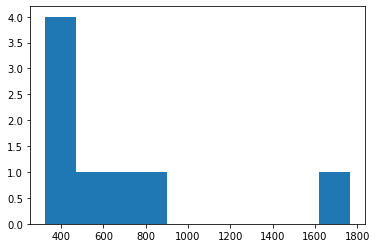

In [23]:
plt.hist(num_by_reviewer.review)
plt.show()

In [24]:
num_by_res= final_reviews.groupby([final_reviews.name]).count()
num_by_res

,address,review,date,link,reviewer,keep,cleaned,cleaned_without_stopwords
name,,,,,,,,
% Arabica (313@Somerset),2,2,2,2,2,2,2,2
% Arabica (Arab Street),2,2,2,2,2,2,2,2
% Arabica (Chip Bee Gardens),6,6,6,6,6,6,6,6
108 Matcha Saro (Suntec City),5,5,5,5,5,5,5,5
136 Hong Kong Street Fish Head Steamboat (Joo Seng),1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...
Shake Shack (Suntec City),1,1,1,1,1,1,1,1
The Coconut Club (Beach Road),1,1,1,1,1,1,1,1
The Frontier (NUS Science Canteen),1,1,1,1,1,1,1,1


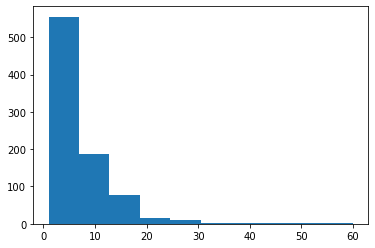

In [25]:
plt.hist(num_by_res.review)
plt.show()

## Word Cloud for reviews for each reviewer and combined

In [26]:
pip install --no-cache-dir wordcloud

Note: you may need to restart the kernel to use updated packages.


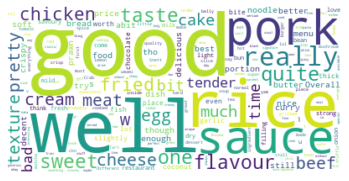

In [44]:
## Word Cloud for final_reviews
#Importing Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import string
from wordcloud import WordCloud, STOPWORDS

# drop address, note, tel, website, Open in reviews
words = []
for r in final_reviews.review:
    if 'Address' not in r and 'Note' not in r and 'Tel' not in r and 'Website' not in r and 'Open' not in r and 'S' not in r:
        words.append(r)

#text = " ".join("".join(review.translate(str.maketrans('','',string.punctuation)).split(" ")) for review in words)
text = " ".join(" ".join(review.split(" ")) for review in words)
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [28]:
unique_reviewers = final_reviews['reviewer'].unique()

Word cloud for each reviewer with stopwords removed

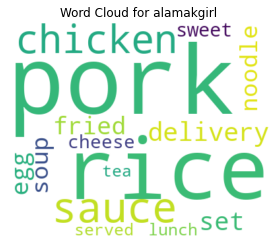

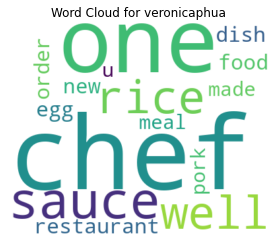

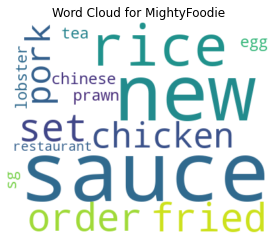

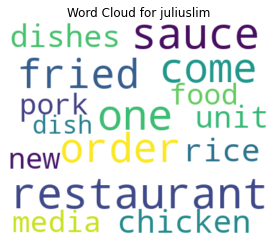

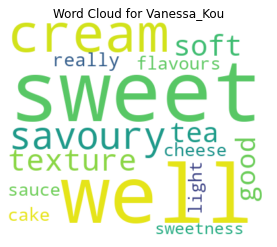

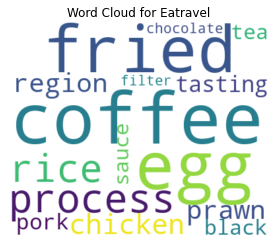

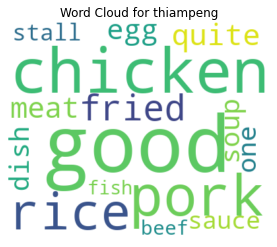

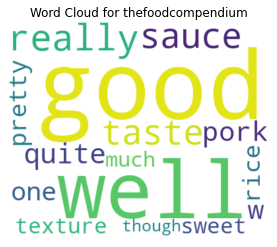

In [29]:
# word cloud for each reviewer
stopwords = set(STOPWORDS)
stopwords.update(["address", "note", "tel", "website", "open", "l", "s", "t", "ve", "liao", "means", "burpplesg", "burpple", "singapore", "road", "menu", "notes", "flavour", "available", "location", "visit", "per"])

for r in unique_reviewers:
    temp = final_reviews[final_reviews["reviewer"] == r]
    words = []
    for i in temp.cleaned_without_stopwords:
        words.append(i)
    #Creating the text variable
    #text = " ".join("".join(review.translate(str.maketrans('','',string.punctuation)).split(" ")) for review in words)
    text = " ".join(" ".join(review.split(" ")) for review in words)
    # Creating word_cloud with text as argument in .generate() method
    word_cloud = WordCloud(width=400, height=330, max_words=15,collocations = False,stopwords=stopwords, background_color = 'white').generate(text)
    # Display the generated Word Cloud
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    title = f"Word Cloud for {r}"
    plt.title(title)
    plt.show()

## Count and plot frequency of post by each reviewer per month

In [30]:
final_reviews['cleaned_date'] = final_reviews.apply(lambda x: 'Mar 2023' if 'ago' in x['date'] else str(x['date'].split("at")[0]+" 2023") if 'at' in x['date'] else str(x['date'].split(", ")[0]+" "+x['date'].split(", ")[-1]), axis = 1)
final_reviews['mmyyyy'] = final_reviews.apply(lambda x: x['cleaned_date'].strip()[:3]+ x['cleaned_date'].strip()[-4:], axis = 1)
final_reviews['DATE'] = pd.to_datetime(final_reviews['mmyyyy'],format='%b%Y')
final_reviews.head()

,name,address,review,date,link,reviewer,keep,cleaned,cleaned_without_stopwords,cleaned_date,mmyyyy,DATE
12,Kazoku Japanese Cuisine,"1 Goldhill Plaza, Singapore ...",\n1-for-1 Don\nKazoku Chirashi Don (S$29.90++)...,4d ago,https://www.burpple.com/kazoku-japanese-cuisin...,alamakgirl,1,for don kazoku chirashi don s thick slices of...,kazoku chirashi thick slices tuna salmon sword...,Mar 2023,Mar2023,2023-03-01
31,Tigerlily Patisserie,"350 Joo Chiat Road, Singapore ...","\nBrunch\nBeehive (S$15+)\nLemon, thyme and ly...",Feb 26 at 12:44pm,https://www.burpple.com/tigerlily-patisserie?b...,alamakgirl,1,brunch beehive s lemon thyme and lychee honey...,brunch beehive lemon thyme lychee honey jelly ...,Feb 26 2023,Feb2023,2023-02-01
32,Putien (Northpoint City) ...,"930 Yishun Avenue 2, Singapore ...",\nBirthday Treat \n20% discount \nValid during...,Feb 24 at 10:47pm,https://www.burpple.com/putien-8?bp_ref=%2Ff%2...,alamakgirl,1,birthday treat discount valid during birthday...,birthday treat discount valid birthday month m...,Feb 24 2023,Feb2023,2023-02-01
35,Our Tampines Hub Hawker Centre (...,"1 Tampines Walk, Singapore ...",\nSet C\nSet C (S$2.50)\n‘Cos it’s Friday \nGo...,Feb 24 at 8:33am,https://www.burpple.com/our-tampines-hub?bp_re...,alamakgirl,1,set c set c s ‘ cos it’s friday got s cashbac...,set c set c ‘ cos it’s friday got cashback pay...,Feb 24 2023,Feb2023,2023-02-01
51,Hokkaido Ramen Santouka (Clarke ...,"6 Eu Tong Sen Street, Singapore ...",\nBirthday Treat\n50% off Tokusen Toroniku Ram...,Feb 19 at 12:27pm,https://www.burpple.com/hokkaido-ramen-santouk...,alamakgirl,1,birthday treat off tokusen toroniku ramen s m...,birthday treat tokusen toroniku ramen it’s nee...,Feb 19 2023,Feb2023,2023-02-01


In [31]:
cal_dict = dict((month, index) for index, month in enumerate(calendar.month_abbr) if month)
cleaned_dates = []
for idx, row in final_reviews.iterrows():
    dt = row['date'].strip()
    if 'ago' in dt:
        if 'm' in dt or 'h' in dt or 's' in dt:
            cleaned_dates.append(date(2023, 3, 15))
        elif 'week' in dt:
            cleaned_dates.append(date(2023, 3, 8))
        else:
            dt_new = int(dt.replace('d ago', ''))
            dt_new = 15- dt_new
            cleaned_dates.append(date(2023, 3, dt_new))
            
    elif 'at' in dt:
        mth_day = dt.split(' ')
        new_date = date(2023, cal_dict[mth_day[0]], int(mth_day[1]))
        if new_date > date(2023,3,15):
            cleaned_dates.append(date(2022,cal_dict[mth_day[0]], int(mth_day[1])))
        else:
            cleaned_dates.append(date(2023, cal_dict[mth_day[0]], int(mth_day[1])))
    
    else:
        mth_day = dt.split(',')[0].split(' ')
        cleaned_dates.append(date(int(dt.split(',')[-1]), cal_dict[mth_day[0]], int(mth_day[1])))

final_reviews['cleaned_dates_datetime'] = cleaned_dates

In [32]:
freq = pd.DataFrame(final_reviews[['reviewer','DATE']].groupby(['reviewer', 'DATE']).size().reset_index())
freq.rename({0:'frequency'}, axis = 1)

,reviewer,DATE,frequency
0,Eatravel,2020-01-01,27
1,Eatravel,2020-02-01,13
2,Eatravel,2020-03-01,14
3,Eatravel,2020-04-01,11
4,Eatravel,2020-05-01,9
...,...,...,...
296,veronicaphua,2022-03-01,1
297,veronicaphua,2022-04-01,7
298,veronicaphua,2022-05-01,5
299,veronicaphua,2022-06-01,4


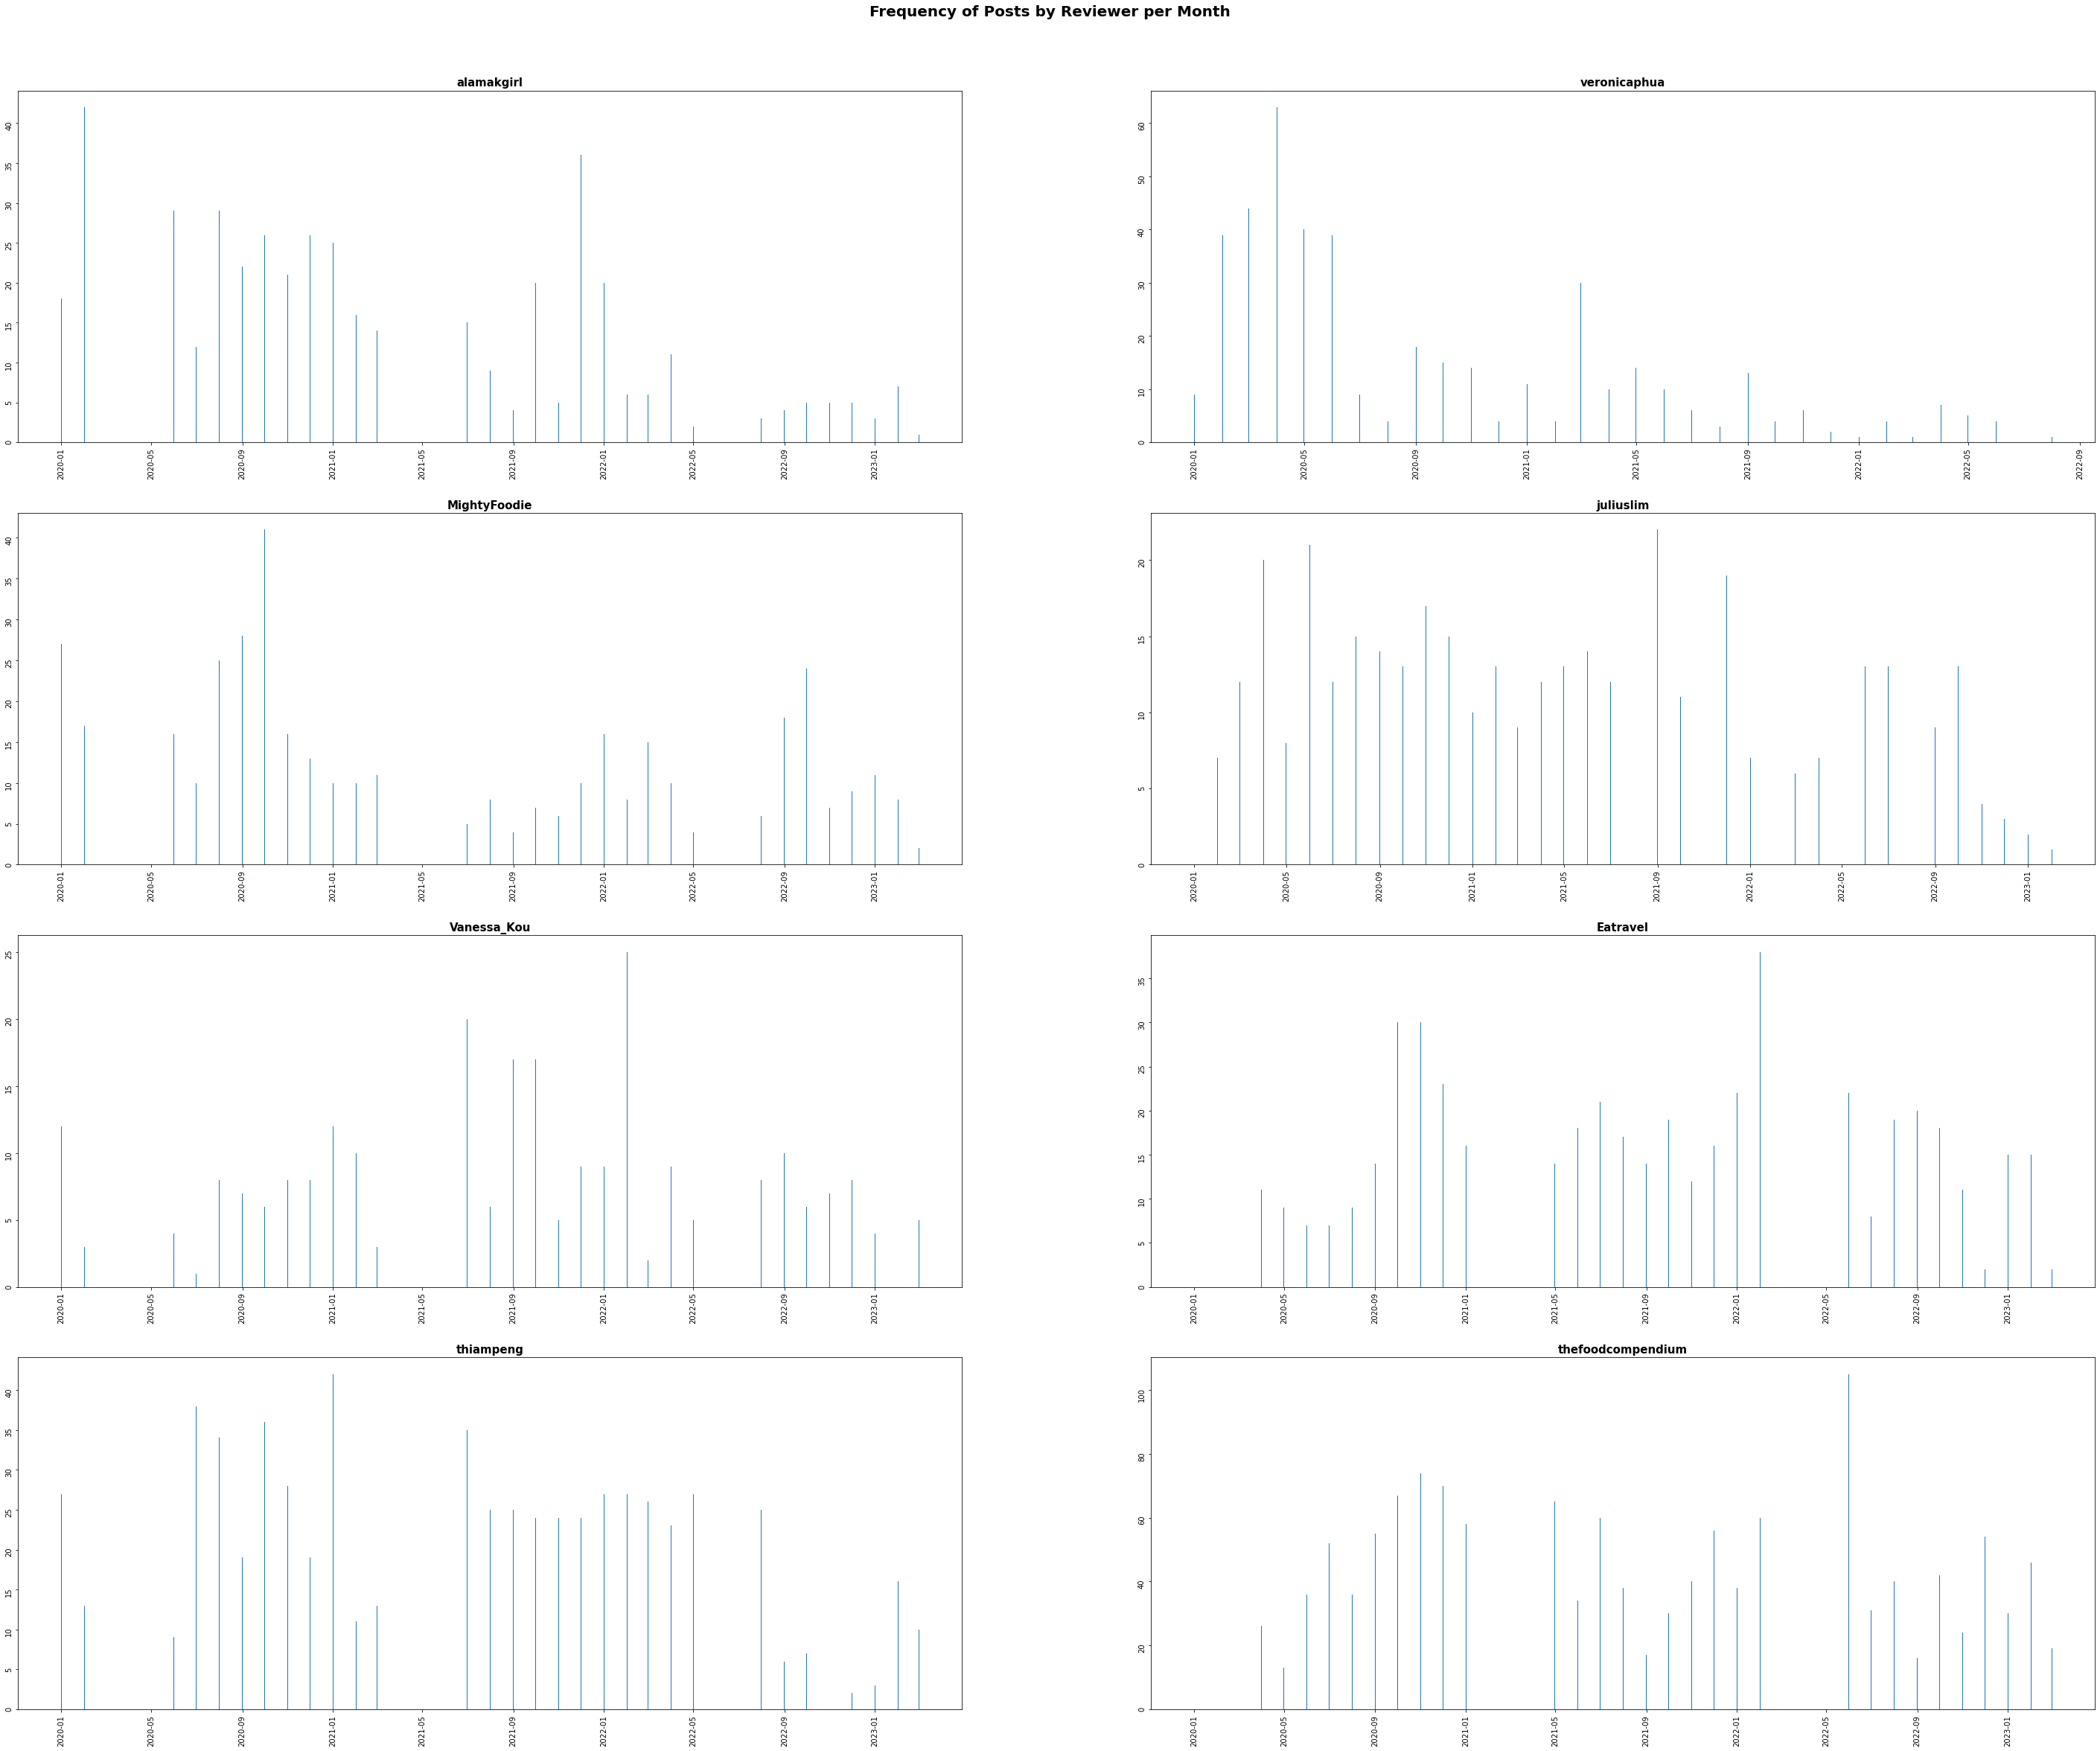

In [33]:
freq_alamakgirl = freq[freq['reviewer'] == 'alamakgirl']
#freq_alamakgirl.rename({0:'frequency'}, axis = 1)
freq_veronicaphua = freq[freq['reviewer'] == 'veronicaphua']
#freq_veronicaphua.rename({0:'frequency'}, axis = 1)
freq_MightyFoodie = freq[freq['reviewer'] == 'MightyFoodie']
#freq_MightyFoodie.rename({0:'frequency'}, axis = 1)
freq_juliuslim = freq[freq['reviewer'] == 'juliuslim']
#freq_juliuslim.rename({0:'frequency'}, axis = 1)
freq_Vanessa_Kou = freq[freq['reviewer'] == 'Vanessa_Kou']
#freq_Vanessa_Kou.rename({0:'frequency'}, axis = 1)
freq_Eatravel = freq[freq['reviewer'] == 'Eatravel']
#freq_Eatravel.rename({0:'frequency'}, axis = 1)
freq_thiampeng = freq[freq['reviewer'] == 'thiampeng']
#freq_thiampeng.rename({0:'frequency'}, axis = 1)
freq_thefoodcompendium = freq[freq['reviewer'] == 'thefoodcompendium']
#freq_thefoodcompendium.rename({0:'frequency'}, axis = 1)


fig, axs = plt.subplots(4,2, figsize=(50, 40))
axs[0][0].bar(freq_alamakgirl['DATE'], freq_alamakgirl[0])
axs[0][1].bar(freq_veronicaphua['DATE'], freq_veronicaphua[0])
axs[1][0].bar(freq_MightyFoodie['DATE'], freq_MightyFoodie[0])
axs[1][1].bar(freq_juliuslim['DATE'], freq_juliuslim[0])
axs[2][0].bar(freq_Vanessa_Kou['DATE'], freq_Vanessa_Kou[0])
axs[2][1].bar(freq_Eatravel['DATE'], freq_Eatravel[0])
axs[3][0].bar(freq_thiampeng['DATE'], freq_thiampeng[0])
axs[3][1].bar(freq_thefoodcompendium['DATE'], freq_thefoodcompendium[0])

fig.suptitle('Frequency of Posts by Reviewer per Month', fontsize=20, fontweight='extra bold', y=0.92, x=0.51)
axs[0][0].set_title('alamakgirl', fontsize=15, fontweight='bold')
axs[0][0].tick_params(labelrotation = 90)

axs[0][1].set_title('veronicaphua', fontsize=15, fontweight='bold')
axs[0][1].tick_params(labelrotation = 90)

axs[1][0].set_title('MightyFoodie', fontsize=15, fontweight='bold')
axs[1][0].tick_params(labelrotation = 90)

axs[1][1].set_title('juliuslim', fontsize=15, fontweight='bold')
axs[1][1].tick_params(labelrotation = 90)

axs[2][0].set_title('Vanessa_Kou', fontsize=15, fontweight='bold')
axs[2][0].tick_params(labelrotation = 90)

axs[2][1].set_title('Eatravel', fontsize=15, fontweight='bold')
axs[2][1].tick_params(labelrotation = 90)

axs[3][0].set_title('thiampeng', fontsize=15, fontweight='bold')
axs[3][0].tick_params(labelrotation = 90)

axs[3][1].set_title('thefoodcompendium', fontsize=15, fontweight='bold')
axs[3][1].tick_params(labelrotation = 90)

In [34]:
freq_by_month = final_reviews.groupby(['DATE']).size().reset_index()
freq_by_month.rename({0:'freq'}, axis = 1)

,DATE,freq
0,2020-01-01,195
1,2020-02-01,151
2,2020-03-01,213
3,2020-04-01,171
4,2020-05-01,121
5,2020-06-01,161
6,2020-07-01,141
7,2020-08-01,160
8,2020-09-01,177
9,2020-10-01,234


Text(0.5, 1.0, 'Frequency of posts by Month')

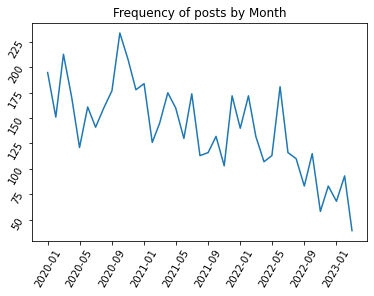

In [35]:
#freq_by_month.plot(x="DATE", y=[0], kind="bar")
plt.plot(freq_by_month['DATE'], freq_by_month[0])
plt.tick_params(labelrotation = 60)
title = "Frequency of posts by Month"
plt.title(title)


In [36]:
df_by_date = final_reviews.groupby('cleaned_dates_datetime')['link'].count().reset_index().iloc[:-8,:]
df_by_date

,cleaned_dates_datetime,link
0,2020-01-01,13
1,2020-01-02,16
2,2020-01-03,13
3,2020-01-04,6
4,2020-01-05,7
...,...,...
1040,2023-02-22,6
1041,2023-02-24,7
1042,2023-02-25,2
1043,2023-02-26,16


Text(0, 0.5, 'Num Reviews Per Month')

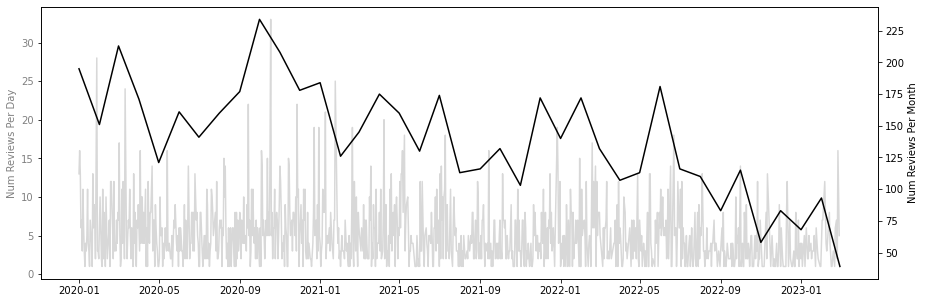

In [37]:
fig, ax1 = plt.subplots(figsize=(15,5))
fig.patch.set_facecolor('white')
ax1.set_facecolor('white')

ax1.plot(df_by_date['cleaned_dates_datetime'],df_by_date['link'],  color = 'grey', alpha = 0.3)
ax1.set_ylabel('Num Reviews Per Day', color = 'grey')
ax1.tick_params(axis = 'y', labelcolor = 'grey')
ax1.grid(False)
ax2 = ax1.twinx()
ax2.plot(freq_by_month['DATE'],freq_by_month[0], color = 'black')
ax2.set_ylabel('Num Reviews Per Month')

## Location of Restaurants Reviewed

In [38]:
locations = final_reviews['address'].unique()
print("No. of locations:", len(locations))

No. of locations: 574


In [39]:
#clean to see area
final_reviews['region'] = final_reviews['address'].apply(lambda x: str(x).replace(', Singapore', ''))
final_reviews['region'] = final_reviews['region'].apply(lambda x: "".join(filter(lambda x: not x.isdigit(),x)))

In [40]:
final_reviews['region'].head(2)

12                   Goldhill Plaza            
31                   Joo Chiat Road            
Name: region, dtype: object

In [41]:
res = final_reviews[['reviewer','region']].groupby('reviewer').nunique().reset_index()
res

,reviewer,region
0,Eatravel,64
1,MightyFoodie,93
2,Vanessa_Kou,57
3,alamakgirl,127
4,juliuslim,147
5,thefoodcompendium,178
6,thiampeng,119
7,veronicaphua,80


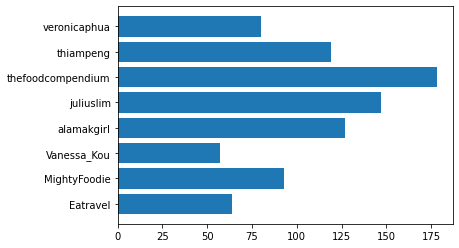

In [42]:
# num of region for each reviewer 
plt.barh(res.reviewer, res.region)
plt.show()

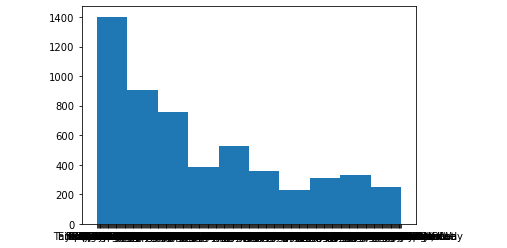

In [43]:
plt.hist(final_reviews.region)
plt.show()